In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import string

from wordcloud import WordCloud

import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("punkt")

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

stop_words = stopwords.words('english')
lem = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martinlane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martinlane/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martinlane/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', index_col = 0)

df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [34]:
df.shape

(23486, 10)

In [35]:
review = df[['Review Text', 'Recommended IND']]
review.head()

,Review Text,Recommended IND
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [36]:
#columns rename
review = review.rename(columns={"Recommended IND": "Recommended", "Review Text": "Review"})
review.head()

,Review,Recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


Text(0.5, 1.0, 'Proportion Target Class')

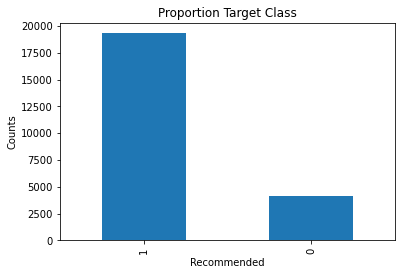

In [37]:
review["Recommended"].value_counts().plot(kind='bar')
plt.xlabel("Recommended")
plt.ylabel("Counts")
plt.title("Proportion Target Class")

In [38]:
review.isnull().sum()

Review         845
Recommended      0
dtype: int64

In [39]:
review.dropna(inplace=True)

In [40]:
review.isnull().sum()

Review         0
Recommended    0
dtype: int64

In [41]:
review.shape

(22641, 2)

In [42]:
def cleaning(data):
    
    #1. Tokenize
    text_tokens = word_tokenize(data.lower())   #removed the .lower intentionaly to keep NNP s
    
    #2. Remove Puncs
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #3. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)

In [43]:
review['Review'] = review['Review'].apply(cleaning)

In [44]:
review.head()

,Review,Recommended
0,absolutely wonderful silky sexy comfortable,1
1,love dress sooo pretty happened find store gla...,1
2,high hope dress really wanted work initially o...,0
3,love love love jumpsuit fun flirty fabulous ev...,1
4,shirt flattering due adjustable front tie perf...,1


In [45]:
df = review.copy()

---
---


In [46]:
positive = review[review.Recommended == 1]
negative = review[review.Recommended == 0]

negative.head()

,Review,Recommended
2,high hope dress really wanted work initially o...,0
5,love tracy reese dress one petite foot tall us...,0
10,dress run small esp zipper area run ordered sp...,0
22,first pullover styling side zipper would purch...,0
25,loved material didnt really look long dress pu...,0


In [47]:
positive.head()

,Review,Recommended
0,absolutely wonderful silky sexy comfortable,1
1,love dress sooo pretty happened find store gla...,1
3,love love love jumpsuit fun flirty fabulous ev...,1
4,shirt flattering due adjustable front tie perf...,1
6,aded basket hte last mintue see would look lik...,1


In [48]:
positive_words =[]

for review in positive.Review:
    positive_words.append(review) 
positive_words = ' '.join(positive_words)
positive_words[:200]

'absolutely wonderful silky sexy comfortable love dress sooo pretty happened find store glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi'

In [49]:
negative_words = []

for review in negative.Review:
    negative_words.append(review)
negative_words = ' '.join(negative_words)
negative_words[:200]

'high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium overall top half comfortable fit nicely bottom half t'

In [50]:
from wordcloud import WordCloud

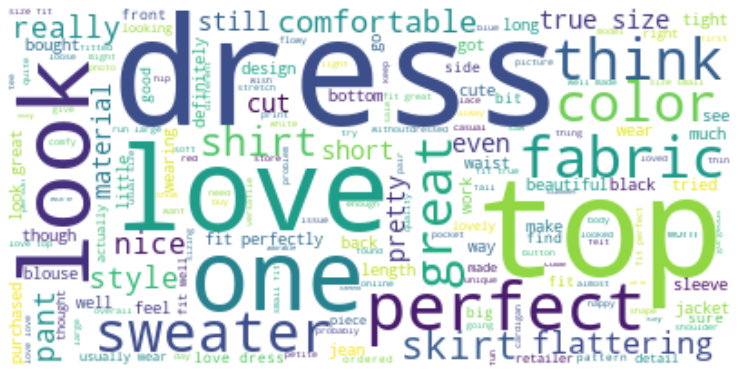

In [51]:
wordcloud = WordCloud(background_color="white", max_words=len(positive_words))

wordcloud.generate(positive_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

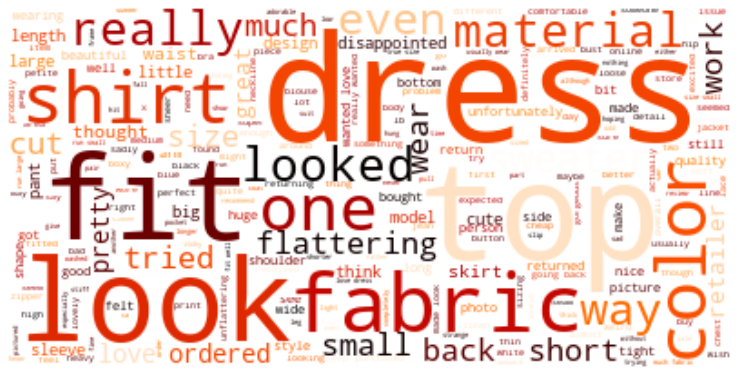

In [52]:
wordcloud = WordCloud(background_color="white", max_words=len(negative_words), colormap='gist_heat')

wordcloud.generate(negative_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [53]:
X = df['Review']
y = df['Recommended']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


In [54]:
X_train.head()

11811    top look better hanger looking feminine plaid ...
8171     much question whether love pant several pair p...
22106    legging warm comfortable thick enough wear pan...
7473                     much lower quality robe purchased
19698    arrived white store airy dreamy try epitome ef...
Name: Review, dtype: object

In the next step we create a numerical feature vector for each document:

In [55]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

CountVectorizer()

In [56]:
X_train_count = vectorizer.transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [59]:
X_train_count

<18112x10806 sparse matrix of type '<class 'numpy.int64'>'
	with 454855 stored elements in Compressed Sparse Row format>

In [60]:
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [57]:
a=pd.DataFrame(X_train_count.toarray())
a.head()

,0,1,2,3,4,5,6,7,8,9,...,10796,10797,10798,10799,10800,10801,10802,10803,10804,10805
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(X_train)

TfidfVectorizer()

In [62]:
X_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train)
X_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

In [63]:
tf_idf_word_vectorizer.get_feature_names()[0:5]

['aa', 'aaaaaaamazing', 'aaaaannnnnnd', 'aaaahmazing', 'aaahed']

In [64]:
b=pd.DataFrame(X_train_tf_idf_word.toarray())

In [65]:
b.head()

,0,1,2,3,4,5,6,7,8,9,...,10796,10797,10798,10799,10800,10801,10802,10803,10804,10805
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
from sklearn.metrics import f1_score

In [67]:
model = LogisticRegression()
model.fit(X_train_count, y_train)


log_count_acc = cross_val_score(model, X_test_count, y_test,cv = 10).mean()
print(log_count_acc)

0.8719387954443338


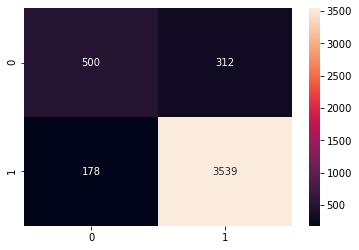

In [69]:
y_pred = model.predict(X_test_count)

cnf_matrix = confusion_matrix(y_test,y_pred) 
sns.heatmap(cnf_matrix,annot=True,fmt="d")

In [72]:
log_count_f1 = f1_score(y_test, y_pred, average='weighted')
log_count_f1

0.887901180187058

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.62      0.67       812
           1       0.92      0.95      0.94      3717

    accuracy                           0.89      4529
   macro avg       0.83      0.78      0.80      4529
weighted avg       0.89      0.89      0.89      4529



In [74]:
model = LogisticRegression()
model.fit(X_train_tf_idf_word, y_train)


log_tf_acc = cross_val_score(model, X_test_tf_idf_word, y_test,cv = 10).mean()
print(log_tf_acc)

0.8653128601848052


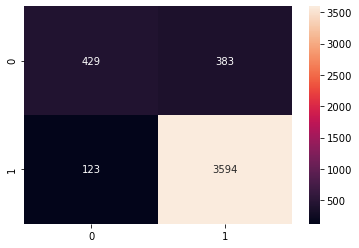

In [75]:
y_pred = model.predict(X_test_tf_idf_word)

cnf_matrix = confusion_matrix(y_test,y_pred) 
sns.heatmap(cnf_matrix,annot=True,fmt="d")

In [76]:
log_tf_f1 = f1_score(y_test, y_pred, average='weighted')
log_tf_f1

0.8795150613058477

In [141]:
X_train

11811    top look better hanger looking feminine plaid ...
8171     much question whether love pant several pair p...
22106    legging warm comfortable thick enough wear pan...
7473                     much lower quality robe purchased
19698    arrived white store airy dreamy try epitome ef...
                               ...                        
12408    bought grey gorgeous color like long length ar...
22387    love love dress got regular size length petite...
5590     bought one tee washed time luckily hole yet li...
901      excited see jean since came petite size short ...
16401              bought sweater love one favorite season
Name: Review, Length: 18112, dtype: object

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.53      0.63       812
           1       0.90      0.97      0.93      3717

    accuracy                           0.89      4529
   macro avg       0.84      0.75      0.78      4529
weighted avg       0.88      0.89      0.88      4529



In [120]:
model = MultinomialNB()
model.fit(X_train_count, y_train)

nb_count_acc = cross_val_score(model, X_test_count, y_test,cv = 10).mean()
print(nb_count_acc)

0.861118599699154


In [121]:
#import pickle

#pickle.dump(model,open("model_nb","wb"))

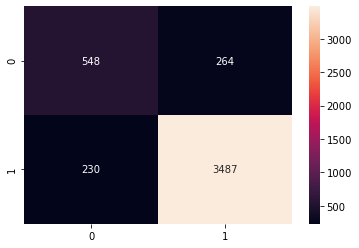

In [79]:
y_pred = model.predict(X_test_count)

cnf_matrix = confusion_matrix(y_test,y_pred) 
sns.heatmap(cnf_matrix,annot=True,fmt="d")

In [80]:
nb_count_f1 = f1_score(y_test, y_pred, average='weighted')
nb_count_f1

0.8900072356651361

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.67      0.69       812
           1       0.93      0.94      0.93      3717

    accuracy                           0.89      4529
   macro avg       0.82      0.81      0.81      4529
weighted avg       0.89      0.89      0.89      4529



In [82]:
model = MultinomialNB()
model.fit(X_train_tf_idf_word, y_train)


nb_tf_acc = cross_val_score(model, X_test_tf_idf_word, y_test,cv = 10).mean()
print(nb_tf_acc)

0.8207109925960655


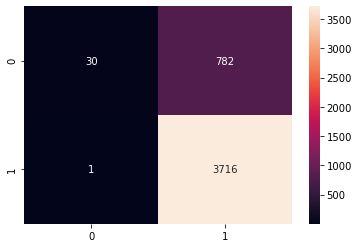

In [83]:
y_pred = model.predict(X_test_tf_idf_word)

cnf_matrix = confusion_matrix(y_test,y_pred) 
sns.heatmap(cnf_matrix,annot=True,fmt="d")

In [85]:
nb_tf_f1 = f1_score(y_test, y_pred, average='weighted')
nb_tf_f1

0.7552469633303628

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.04      0.07       812
           1       0.83      1.00      0.90      3717

    accuracy                           0.83      4529
   macro avg       0.90      0.52      0.49      4529
weighted avg       0.85      0.83      0.76      4529



### Support Vector Machine (SVM)

In [86]:
model = SVC()
model.fit(X_train_count, y_train)

svm_count_acc = cross_val_score(model, X_test_count, y_test,cv = 10).mean()
print(svm_count_acc)



0.8686270487800114


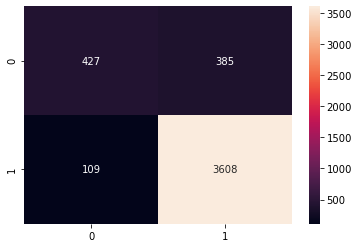

In [87]:
y_pred = model.predict(X_test_count)

cnf_matrix = confusion_matrix(y_test,y_pred) 
sns.heatmap(cnf_matrix,annot=True,fmt="d")

In [88]:
svm_count_f1 = f1_score(y_test, y_pred, average='weighted')
svm_count_f1

0.8817110450540003

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.53      0.63       812
           1       0.90      0.97      0.94      3717

    accuracy                           0.89      4529
   macro avg       0.85      0.75      0.78      4529
weighted avg       0.88      0.89      0.88      4529



In [90]:
model = SVC()
model.fit(X_train_tf_idf_word, y_train)


svm_tf_acc = cross_val_score(model, X_test_tf_idf_word, y_test,cv = 10).mean()
print(svm_tf_acc)

0.8679633319658521


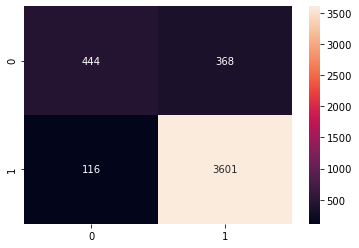

In [91]:
y_pred = model.predict(X_test_tf_idf_word)

cnf_matrix = confusion_matrix(y_test,y_pred) 
sns.heatmap(cnf_matrix,annot=True,fmt="d")

In [92]:
svm_tf_f1 = f1_score(y_test, y_pred, average='weighted')
svm_tf_f1

0.8850707543911839

In [93]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.55      0.65       812
           1       0.91      0.97      0.94      3717

    accuracy                           0.89      4529
   macro avg       0.85      0.76      0.79      4529
weighted avg       0.89      0.89      0.89      4529



### Random Forest

In [94]:
model = RandomForestClassifier()
model.fit(X_train_count, y_train)

rf_count_acc = cross_val_score(model, X_test_count, y_test,cv = 10).mean()
print(rf_count_acc)

0.8412481197132197


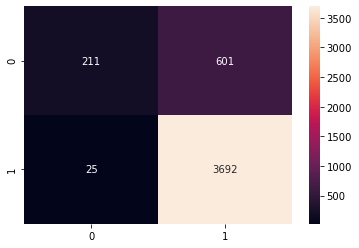

In [95]:
y_pred = model.predict(X_test_count)

cnf_matrix = confusion_matrix(y_test,y_pred) 
sns.heatmap(cnf_matrix,annot=True,fmt="d")

In [103]:
rf_count_f1 = f1_score(y_test, y_pred, average='weighted')
rf_count_f1

0.8287651425960244

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.26      0.40       812
           1       0.86      0.99      0.92      3717

    accuracy                           0.86      4529
   macro avg       0.88      0.63      0.66      4529
weighted avg       0.87      0.86      0.83      4529



In [104]:
model = RandomForestClassifier()
model.fit(X_train_tf_idf_word, y_train)


rf_tf_acc = cross_val_score(model, X_test_tf_idf_word, y_test,cv = 10).mean()
print(rf_tf_acc)

0.8390406141944557


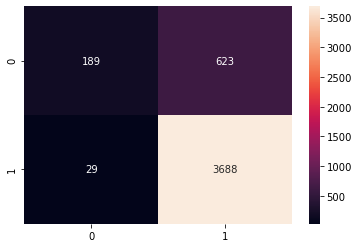

In [105]:
y_pred = model.predict(X_test_tf_idf_word)

cnf_matrix = confusion_matrix(y_test,y_pred) 
sns.heatmap(cnf_matrix,annot=True,fmt="d")

In [106]:
rf_tf_f1 = f1_score(y_test, y_pred, average='weighted')
rf_tf_f1

0.8198536526248704

In [107]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.23      0.37       812
           1       0.86      0.99      0.92      3717

    accuracy                           0.86      4529
   macro avg       0.86      0.61      0.64      4529
weighted avg       0.86      0.86      0.82      4529



In [108]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train_count, y_train)

ada_count_acc = cross_val_score(model, X_test_count, y_test,cv = 10).mean()
print(ada_count_acc)

0.8595762761530799


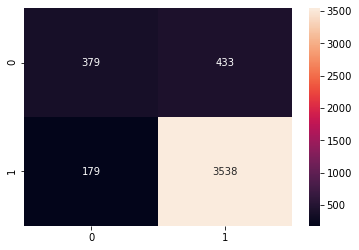

In [109]:
y_pred = model.predict(X_test_count)

cnf_matrix = confusion_matrix(y_test,y_pred) 
sns.heatmap(cnf_matrix,annot=True,fmt="d")

In [110]:
ada_count_f1 = f1_score(y_test, y_pred, average='weighted')
ada_count_f1

0.8545764925507396

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.47      0.55       812
           1       0.89      0.95      0.92      3717

    accuracy                           0.86      4529
   macro avg       0.79      0.71      0.74      4529
weighted avg       0.85      0.86      0.85      4529



In [112]:
model = AdaBoostClassifier()
model.fit(X_train_tf_idf_word, y_train)


ada_tf_acc = cross_val_score(model, X_test_tf_idf_word, y_test,cv = 10).mean()
print(ada_tf_acc)

0.8567035886616265


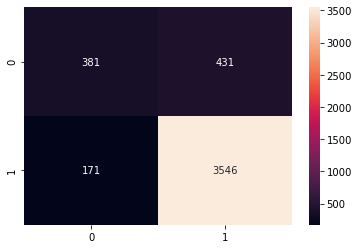

In [113]:
y_pred = model.predict(X_test_tf_idf_word)

cnf_matrix = confusion_matrix(y_test,y_pred) 
sns.heatmap(cnf_matrix,annot=True,fmt="d")

In [114]:
ada_tf_f1 = f1_score(y_test, y_pred, average='weighted')
ada_tf_f1

0.8566562587077475

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.47      0.56       812
           1       0.89      0.95      0.92      3717

    accuracy                           0.87      4529
   macro avg       0.79      0.71      0.74      4529
weighted avg       0.86      0.87      0.86      4529



Text(0.5, 1.0, 'Cv Score of Different Models')

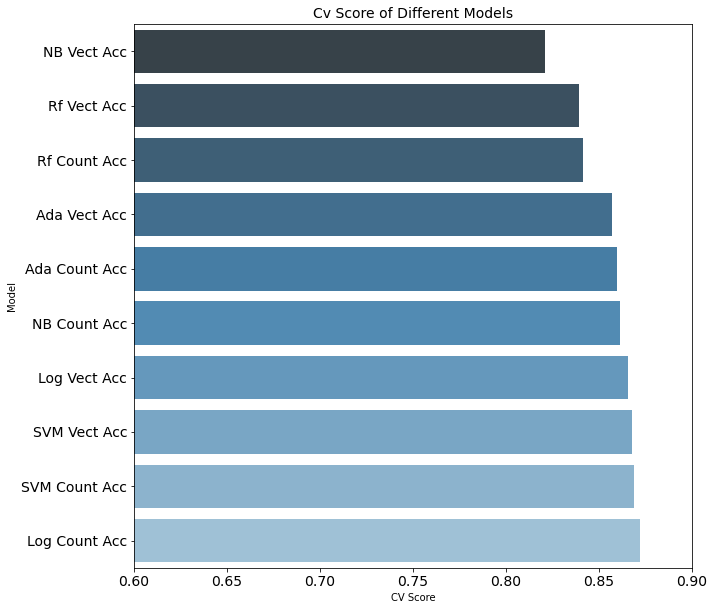

In [116]:
compare = pd.DataFrame({"Model": ["Log Count Acc", "Log Vect Acc", "NB Count Acc", "NB Vect Acc",
                                  "SVM Count Acc","SVM Vect Acc","Ada Count Acc","Ada Vect Acc","Rf Count Acc","Rf Vect Acc"],
                        "CV Score": [log_count_acc, log_tf_acc, nb_count_acc, nb_tf_acc, svm_count_acc, svm_tf_acc,ada_count_acc,ada_tf_acc,rf_count_acc,rf_tf_acc]})

compare = compare.sort_values(by="CV Score", ascending=True)

plt.figure(figsize=(10,10))
ax = sns.barplot(x="CV Score", y="Model", data=compare, palette="Blues_d")
ax.set_xlim(.60, .90)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("Cv Score of Different Models", size=14)

Text(0.5, 1.0, 'F1 Score of Different Models')

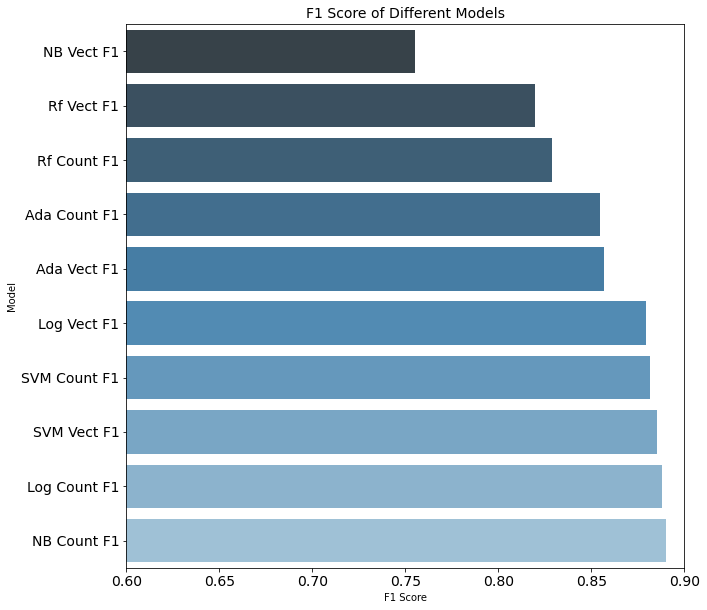

In [119]:
compare = pd.DataFrame({"Model": ["Log Count F1", "Log Vect F1", "NB Count F1", "NB Vect F1",
                                  "SVM Count F1","SVM Vect F1","Ada Count F1","Ada Vect F1","Rf Count F1","Rf Vect F1"],
                        "F1 Score": [log_count_f1, log_tf_f1, nb_count_f1, nb_tf_f1, svm_count_f1, svm_tf_f1,ada_count_f1,ada_tf_f1,rf_count_f1,rf_tf_f1]})

compare = compare.sort_values(by="F1 Score", ascending=True)

plt.figure(figsize=(10,10))
ax = sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")
ax.set_xlim(.60, .90)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("F1 Score of Different Models", size=14)

In [122]:
nb_model = pickle.load(open("model_nb","rb"))

In [184]:
comment = "I did not like the way this dress fit, the waist was WAY to high and bi, but the chest WAY toooooo small. The length was perfect as were the sleeves."

In [185]:
comment_s = pd.Series(comment)

In [186]:
vect = CountVectorizer()
vect.fit(X_train)


CountVectorizer()

In [187]:
transformed_comment = vect.transform(comment_s)
c = pd.DataFrame(transformed_comment.toarray())
c.head()


,0,1,2,3,4,5,6,7,8,9,...,10796,10797,10798,10799,10800,10801,10802,10803,10804,10805
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
nb_model.predict(transformed_comment)

array([1])